In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Subset
from sklearn.model_selection import KFold
from torchvision import models
from sklearn.metrics import confusion_matrix,classification_report
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAUROC
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import timm

c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = datasets.ImageFolder(root="./Brain MRI ND-5 Dataset/tumordata/Training", transform=transform)
test_dataset = datasets.ImageFolder(root="./Brain MRI ND-5 Dataset/tumordata/Testing", transform=transform)


In [5]:
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=16,persistent_workers=True)

In [6]:
class VGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(VGG16, self).__init__()
        base_model = models.vgg16(pretrained=True)
        self.encoder = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) 
        self.flatten_dim = 512 
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(self.flatten_dim),
            nn.Linear(self.flatten_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.7),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

In [7]:
model = VGG16(num_classes=4)

c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True)

In [53]:
NUM_CLASSES = 4
BATCH_SIZE = 16
NUM_EPOCHS = 25
K_FOLDS = 10
PATIENCE = 5
LR = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = 'checkpoints_VGG16'
os.makedirs(SAVE_DIR, exist_ok=True)


In [11]:
def train(model, criterion, optimizer, scheduler, k_folds=10, patience=5, 
          num_epochs=25, save_dir=SAVE_DIR, batch_size=32, device='cuda'):

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_model = model.to(device)
    os.makedirs(save_dir, exist_ok=True)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        print(f"\n--- Fold {fold + 1}/{k_folds} ---")
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                  pin_memory=True, num_workers=18, drop_last=True, persistent_workers=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                                pin_memory=True, num_workers=4, persistent_workers=True)

        # Metrics
        accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, average='macro').to(device)
        precision = MulticlassPrecision(num_classes=NUM_CLASSES, average='macro').to(device)
        recall = MulticlassRecall(num_classes=NUM_CLASSES, average='macro').to(device)
        f1 = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro').to(device)
        auc = MulticlassAUROC(num_classes=NUM_CLASSES, average='macro').to(device)

        fold_metrics = []
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        early_stopping_flag = False
        best_model_wts = None

        fold_checkpoint_dir = os.path.join(save_dir, f"fold_{fold + 1}")
        os.makedirs(fold_checkpoint_dir, exist_ok=True)

        for epoch in range(num_epochs):
            if early_stopping_flag:
                print(f"Early stopping at epoch {epoch + 1}")
                break

            # ------------------ Training ------------------
            fold_model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = fold_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                accuracy.update(outputs, labels)
                precision.update(outputs, labels)
                recall.update(outputs, labels)
                f1.update(outputs, labels)
                auc.update(outputs, labels)

            avg_train_loss = running_loss / len(train_loader)
            train_acc = accuracy.compute()
            train_prec = precision.compute()
            train_recall = recall.compute()
            train_f1 = f1.compute()
            train_auc = auc.compute()

            accuracy.reset()
            precision.reset()
            recall.reset()
            f1.reset()
            auc.reset()

            # ------------------ Validation ------------------
            fold_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = fold_model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    accuracy.update(outputs, labels)
                    precision.update(outputs, labels)
                    recall.update(outputs, labels)
                    f1.update(outputs, labels)
                    auc.update(outputs, labels)

            avg_val_loss = val_loss / len(val_loader)
            val_acc = accuracy.compute()
            val_prec = precision.compute()
            val_recall = recall.compute()
            val_f1 = f1.compute()
            val_auc = auc.compute()
            accuracy.reset()
            precision.reset()
            recall.reset()
            f1.reset()
            auc.reset()

            if scheduler is not None:
                scheduler.step(avg_val_loss)

            print(f"Epoch {epoch + 1}/{num_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, "
                  f"Recall: {train_recall:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, "
                  f"Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

            epoch_metrics = {
                'fold': fold + 1,
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'train_accuracy': train_acc.item(),
                'train_precision': train_prec.item(),
                'train_recall': train_recall.item(),
                'train_f1': train_f1.item(),
                'train_auc': train_auc.item(),
                'val_loss': avg_val_loss,
                'val_accuracy': val_acc.item(),
                'val_precision': val_prec.item(),
                'val_recall': val_recall.item(),
                'val_f1': val_f1.item(),
                'val_auc': val_auc.item(),
            }

            fold_metrics.append(epoch_metrics)
            all_metrics.append(epoch_metrics)

            if avg_val_loss < best_val_loss:
                print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
                best_val_loss = avg_val_loss
                epochs_without_improvement = 0
                best_model_wts = copy.deepcopy(fold_model.state_dict())
                torch.save(best_model_wts, os.path.join(fold_checkpoint_dir, 'best_model.pth'))
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    early_stopping_flag = True

        fold_df = pd.DataFrame(fold_metrics)
        fold_df.to_csv(os.path.join(fold_checkpoint_dir, f"fold_{fold + 1}_metrics.csv"), index=False)
        fold_model.load_state_dict(best_model_wts)

    all_metrics_df = pd.DataFrame(all_metrics)
    all_metrics_df.to_csv(os.path.join(save_dir, 'kfold_metrics.csv'), index=False)

    return model, all_metrics_df


In [49]:
torch.cuda.empty_cache()

In [50]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(0.)

In [14]:
model,all_fold_metrics_df = train(model,criterion, optimizer, scheduler)


--- Fold 1/10 ---
Epoch 1/25 | Train Loss: 0.7610, Acc: 0.6979, Prec: 0.6886, Recall: 0.6979, F1: 0.6911, AUC: 0.8918 | Val Loss: 0.8461, Acc: 0.6266, Prec: 0.7902, Recall: 0.6266, F1: 0.6158, AUC: 0.9399
Validation loss improved from inf to 0.8461
Epoch 2/25 | Train Loss: 0.4344, Acc: 0.8391, Prec: 0.8330, Recall: 0.8391, F1: 0.8355, AUC: 0.9607 | Val Loss: 1.3513, Acc: 0.6259, Prec: 0.7378, Recall: 0.6259, F1: 0.5692, AUC: 0.9420
Epoch 3/25 | Train Loss: 0.3512, Acc: 0.8707, Prec: 0.8664, Recall: 0.8707, F1: 0.8682, AUC: 0.9742 | Val Loss: 1.8561, Acc: 0.8814, Prec: 0.8730, Recall: 0.8814, F1: 0.8699, AUC: 0.9772
Epoch 4/25 | Train Loss: 0.2794, Acc: 0.8973, Prec: 0.8955, Recall: 0.8973, F1: 0.8963, AUC: 0.9835 | Val Loss: 2.2436, Acc: 0.7642, Prec: 0.7971, Recall: 0.7642, F1: 0.7287, AUC: 0.9749
Epoch 5/25 | Train Loss: 0.2479, Acc: 0.9174, Prec: 0.9155, Recall: 0.9174, F1: 0.9164, AUC: 0.9871 | Val Loss: 0.5190, Acc: 0.8034, Prec: 0.8618, Recall: 0.8034, F1: 0.7988, AUC: 0.9892
Va

In [15]:
# Save the model
torch.save(model.state_dict(), "vgg16_tumor.pth")
print("Model saved successfully!")

Model saved successfully!


In [9]:
model.load_state_dict(torch.load("vgg16_tumor.pth", map_location='cuda'))
model.eval()

C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_11540\1595518485.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vgg16_tumor.pth", ma

VGG16(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [18]:
print(all_fold_metrics_df.head())

   fold  epoch  train_loss  train_accuracy  train_precision  train_recall  \
0     1      1    0.760984        0.697865         0.688622      0.697865   
1     1      2    0.434373        0.839086         0.832971      0.839086   
2     1      3    0.351176        0.870748         0.866352      0.870748   
3     1      4    0.279372        0.897279         0.895465      0.897279   
4     1      5    0.247933        0.917369         0.915487      0.917369   

   train_f1  train_auc  val_loss  val_accuracy  val_precision  val_recall  \
0  0.691075   0.891805  0.846098      0.626632       0.790156    0.626632   
1  0.835465   0.960724  1.351335      0.625904       0.737846    0.625904   
2  0.868219   0.974213  1.856052      0.881407       0.873035    0.881407   
3  0.896275   0.983500  2.243607      0.764168       0.797063    0.764168   
4  0.916374   0.987136  0.519025      0.803387       0.861842    0.803387   

     val_f1   val_auc  
0  0.615845  0.939896  
1  0.569248  0.941991  
2 

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

VGG16(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [11]:
from sklearn.metrics import precision_score, recall_score
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = (2*precision*recall)/(precision+recall)
accuracy =correct / total

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.9594
Test Precision: 0.9583
Test Recall: 0.9621
Test F1-Score: 0.9602


In [12]:
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset

In [13]:
ext_test_ts = "./MRI Dataset (Tumor)/Testing"
ext_test_tr = "./MRI Dataset (Tumor)/Training"

ext_tr_dataset = ImageFolder(ext_test_tr,transform)
ext_ts_dataset = ImageFolder(ext_test_ts,transform)
ext_test_dataset = ConcatDataset([ext_tr_dataset,ext_ts_dataset])
ext_test_loader = DataLoader(ext_test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True)

In [14]:
from sklearn.metrics import precision_score, recall_score
correct = 0
total = 0
all_preds_ext = []
all_labels_ext = []
all_probs_ext = []

with torch.no_grad():
    for images, labels in ext_test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds_ext.extend(predicted.cpu().numpy())
        all_labels_ext.extend(labels.cpu().numpy())
        all_probs_ext.extend(probs.cpu().numpy())
all_preds_ext = np.array(all_preds_ext)
all_labels_ext = np.array(all_labels_ext)
precision = precision_score(all_labels_ext, all_preds_ext, average='macro')
recall = recall_score(all_labels_ext, all_preds_ext, average='macro')
f1 = (2*precision*recall)/(precision+recall)
accuracy =correct / total

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.9932
Test Precision: 0.9929
Test Recall: 0.9928
Test F1-Score: 0.9928


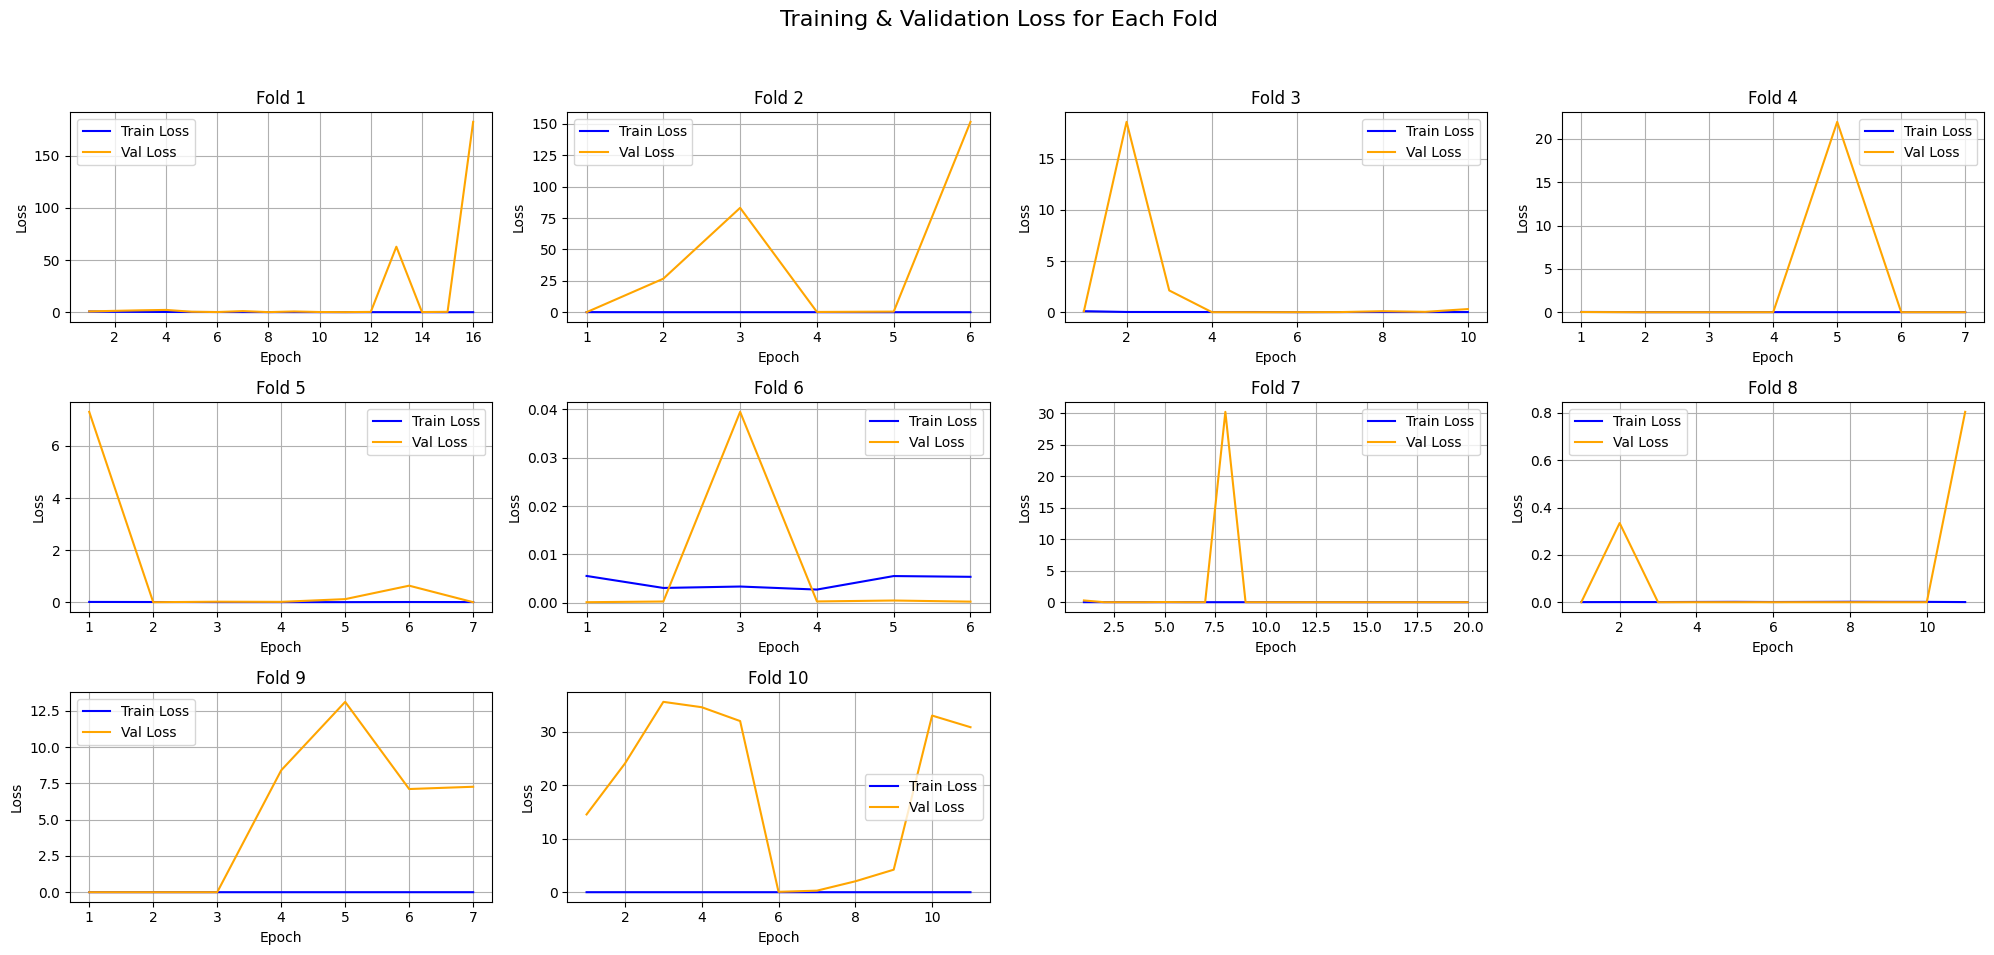

In [ ]:
folds = sorted(all_fold_metrics_df['fold'].unique())
num_folds = len(folds)
cols = 4
rows = (num_folds + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.flatten()  
for i, fold in enumerate(folds):
    ax = axes[i]
    fold_data = all_fold_metrics_df[all_fold_metrics_df['fold'] == fold]
    
    ax.plot(fold_data['epoch'], fold_data['train_loss'], label='Train Loss', color='blue')
    ax.plot(fold_data['epoch'], fold_data['val_loss'], label='Val Loss', color='orange')
    ax.set_title(f'Fold {fold}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.suptitle('Training & Validation Loss for Each Fold', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


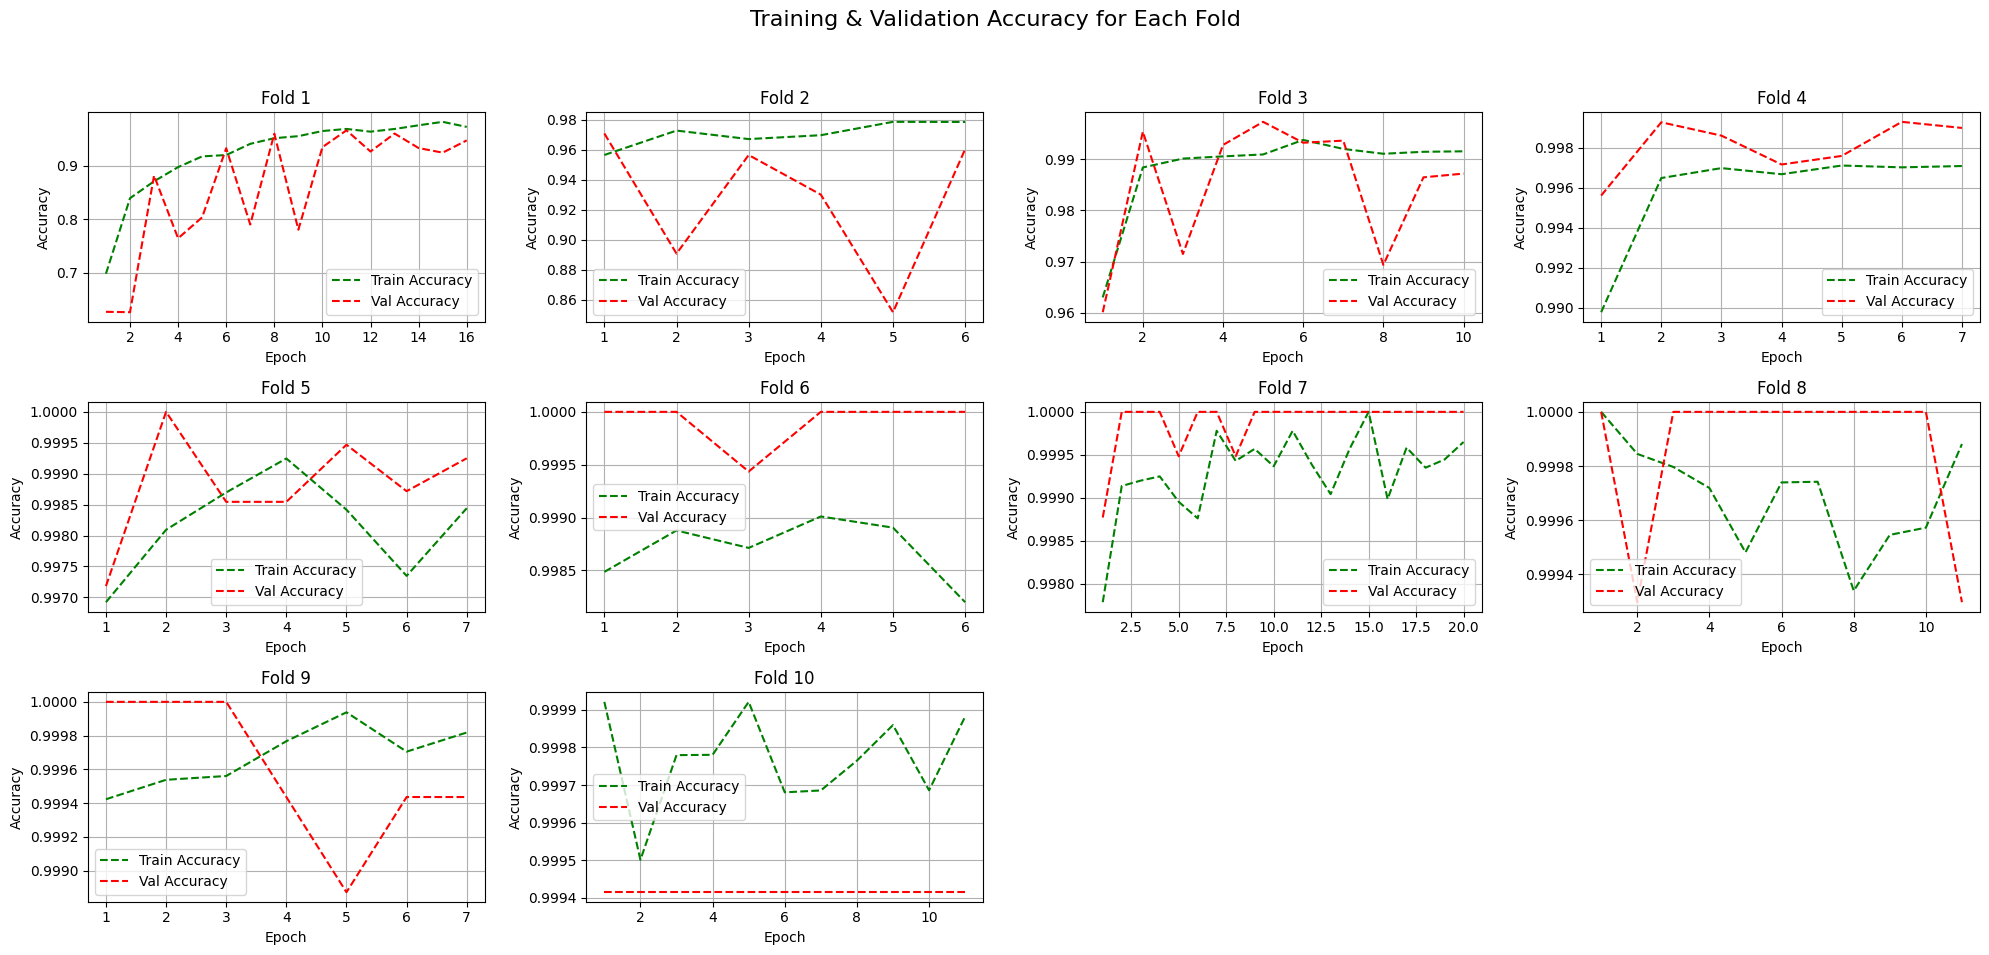

In [ ]:

folds = sorted(all_fold_metrics_df['fold'].unique())
num_folds = len(folds)
cols = 4
rows = (num_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, fold in enumerate(folds):
    
    ax = axes[i]
    fold_data = all_fold_metrics_df[all_fold_metrics_df['fold'] == fold]
    ax.plot(fold_data['epoch'], fold_data['train_accuracy'], label='Train Accuracy', color='green', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['val_accuracy'], label='Val Accuracy', color='red', linestyle='--')

    ax.set_title(f'Fold {fold}')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Training & Validation Accuracy for Each Fold', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


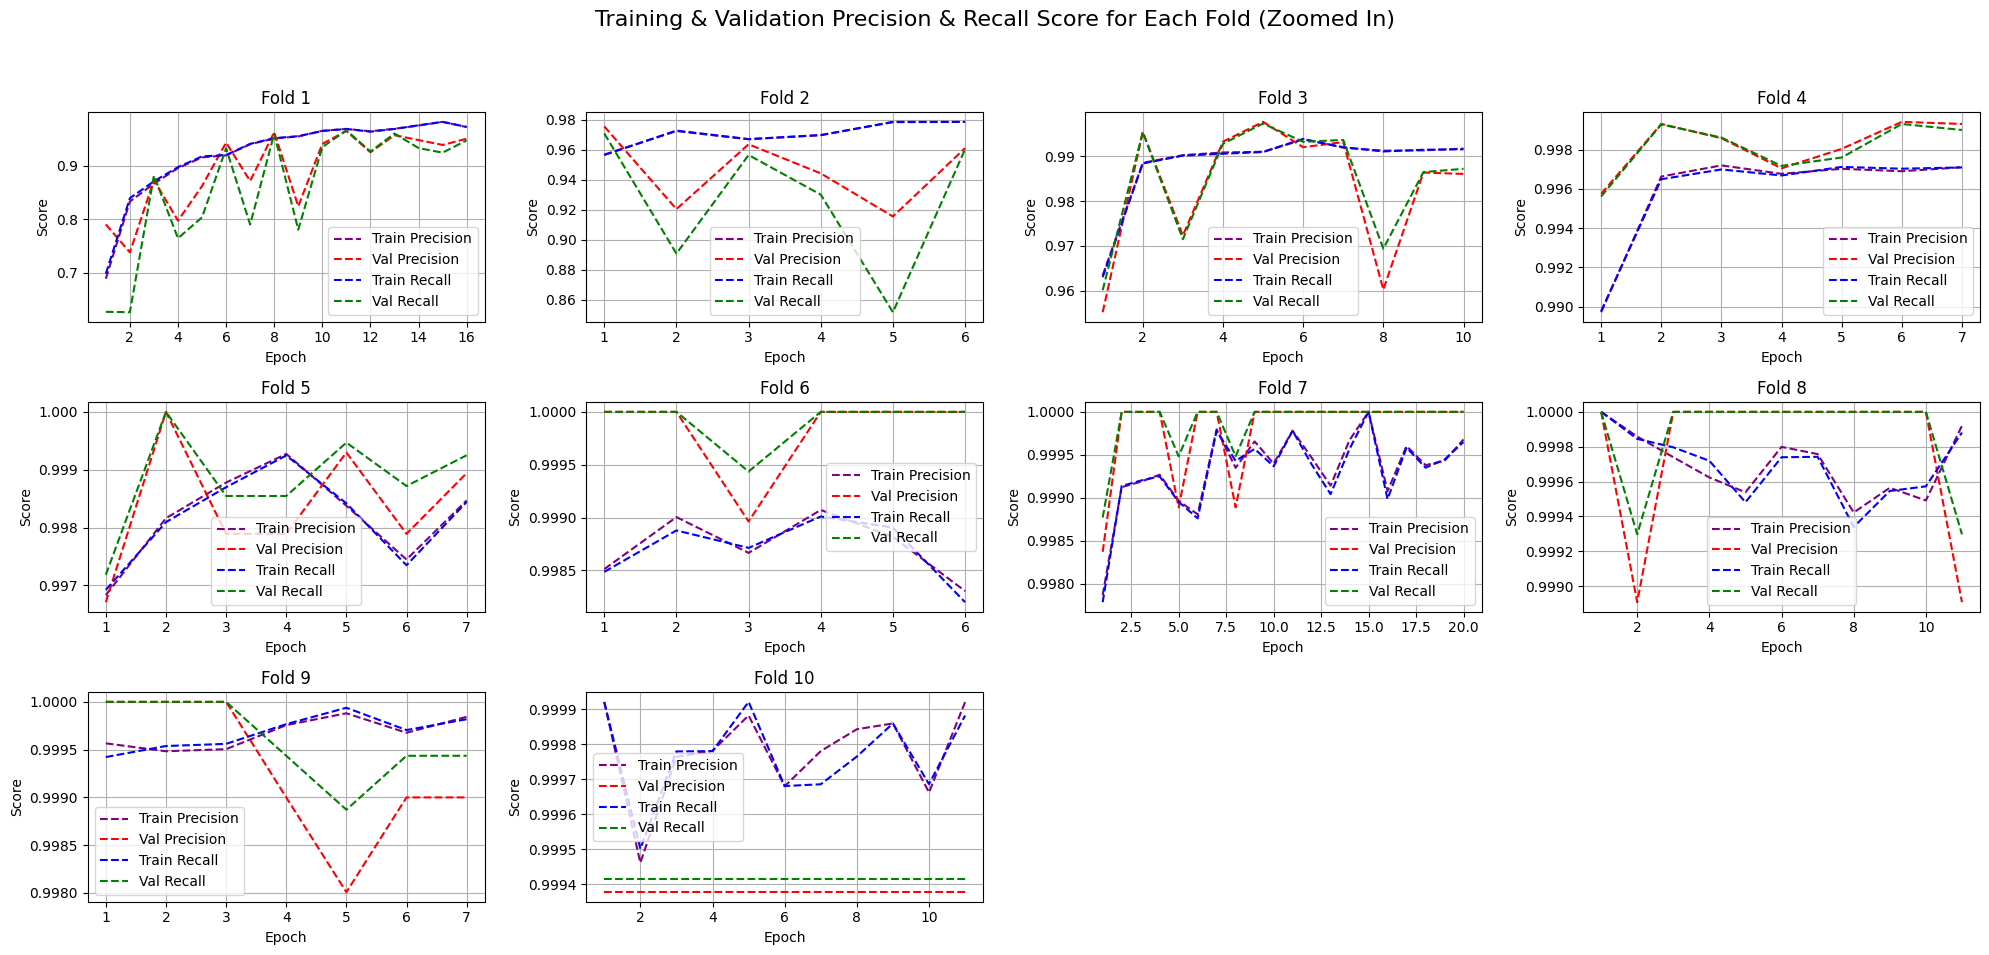

In [ ]:

folds = sorted(all_fold_metrics_df['fold'].unique())
num_folds = len(folds)
cols = 4
rows = (num_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, fold in enumerate(folds):
    
    ax = axes[i]
    fold_data = all_fold_metrics_df[all_fold_metrics_df['fold'] == fold]
    ax.plot(fold_data['epoch'], fold_data['train_precision'], label='Train Precision', color='purple', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['val_precision'], label='Val Precision', color='red', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['train_recall'], label='Train Recall', color='blue', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['val_recall'], label='Val Recall', color='green', linestyle='--')

    ax.set_title(f'Fold {fold}')

    ax.set_ylabel('Score')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.suptitle('Training & Validation Precision & Recall Score for Each Fold (Zoomed In)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


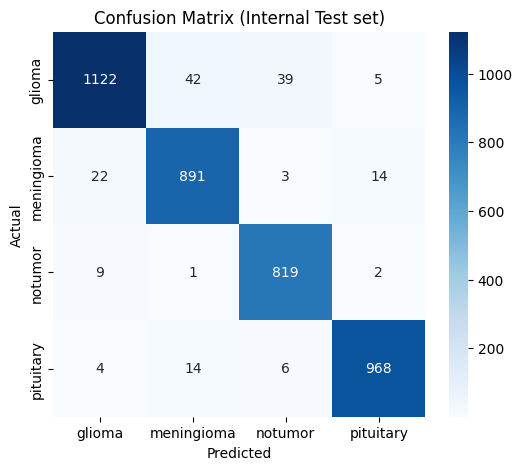

In [15]:
class_names = os.listdir("./MRI Dataset (Tumor)/Training")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Internal Test set)")
plt.show()


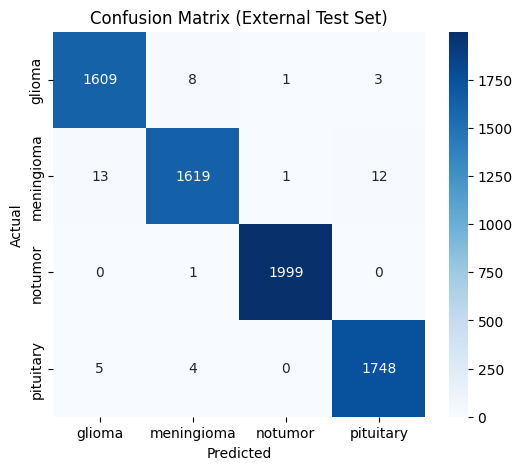

In [16]:

class_names = os.listdir("./MRI Dataset (Tumor)/Training")
cm = confusion_matrix(all_labels_ext, all_preds_ext)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (External Test Set)")
plt.show()


In [34]:

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95      1208
  meningioma       0.94      0.96      0.95       930
     notumor       0.94      0.99      0.96       831
   pituitary       0.98      0.98      0.98       992

    accuracy                           0.96      3961
   macro avg       0.96      0.96      0.96      3961
weighted avg       0.96      0.96      0.96      3961



In [35]:

print(classification_report(all_labels_ext, all_preds_ext, target_names=class_names))


              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99      1621
  meningioma       0.99      0.98      0.99      1645
     notumor       1.00      1.00      1.00      2000
   pituitary       0.99      0.99      0.99      1757

    accuracy                           0.99      7023
   macro avg       0.99      0.99      0.99      7023
weighted avg       0.99      0.99      0.99      7023



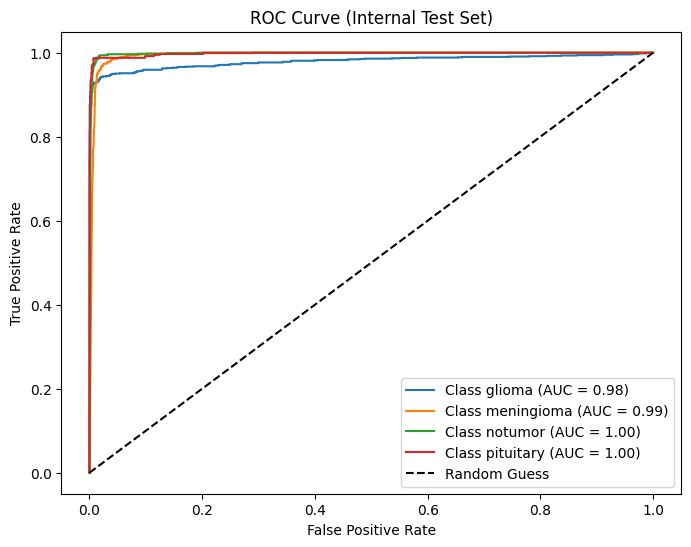

In [36]:
all_labels_onehot = label_binarize(all_labels, classes=[0, 1, 2, 3])
all_preds_probs = np.array(all_probs)

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_preds_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Internal Test Set)")
plt.legend()
plt.show()


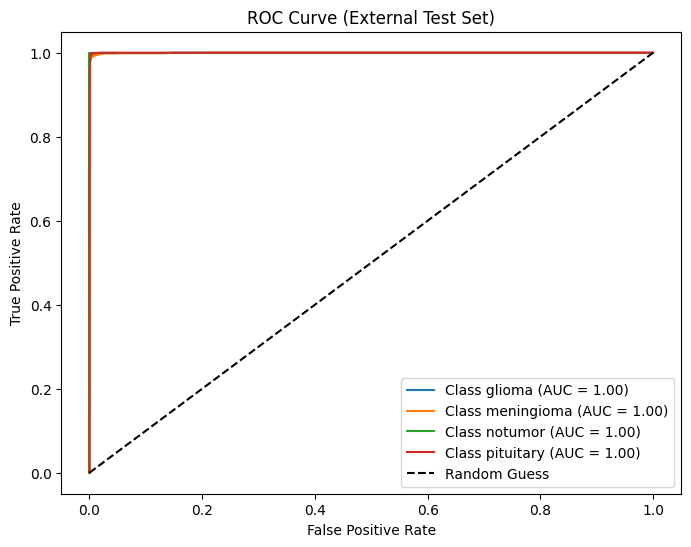

In [37]:
all_labels_onehot_ext = label_binarize(all_labels_ext, classes=[0, 1, 2, 3])
all_preds_probs_ext = np.array(all_probs_ext)

plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(all_labels_onehot_ext[:, i], all_preds_probs_ext[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (External Test Set)")
plt.legend()
plt.show()